# Workshop Notebook 2: Deploy Pipeline to Edge Devices

For this workshop, we will take a Wallaroo pipeline and publish it to an Open Container (OCI) Registry.  The registry details are stored in the Wallaroo instance as the Edge Registry.  

In this set of exercises, you will:

1. Use a pre-trained model and deploy it to Wallaroo.
1. Perform sample inferences.
1. Publish the pipeline to the Edge Registry.
1. See the steps to deploy the published pipeline to an Edge device and perform inferences through it.

Deployment to the Edge allows data scientists to work in Wallaroo to test their models in Wallaroo, then once satisfied with the results publish those pipelines.  DevOps engineers then take those published pipeline details from the Edge registry and deploy them into Docker and Kubernetes environments.

This workshop will demonstrate the following concepts:

* [Wallaroo Workspaces](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/):  Workspaces are environments were users upload models, create pipelines and other artifacts.  The workspace should be considered the fundamental area where work is done.  Workspaces are shared with other users to give them access to the same models, pipelines, etc.
* [Wallaroo Model Upload and Registration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/): ML Models are uploaded to Wallaroo through the SDK or the MLOps API to a **workspace**.  ML models include default runtimes (ONNX, Python Step, and TensorFlow) that are run directly through the Wallaroo engine, and containerized runtimes (Hugging Face, PyTorch, etc) that are run through in a container through the Wallaroo engine.
* [Wallaroo Pipelines](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/): Pipelines are used to deploy models for inferencing.  Each model is a **pipeline step** in a pipelines, where the inputs of the previous step are fed into the next.  Pipeline steps can be ML models, Python scripts, or Arbitrary Python (these contain necessary models and artifacts for running a model).
* [Pipeline Edge Publication](https://docs.wallaroo.ai/20230300/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/): How to publish a Wallaroo pipeline to an OCI registry, then deploy that pipeline into other environments.

For this tutorial, we will be providing pre-trained models in ONNX format, and have connected a sample Edge Registry to our Wallaroo instance.

For more Wallaroo procedures, see the [Wallaroo Documentation site](https://docs.wallaroo.ai).

## Preliminaries

In the blocks below we will preload some required libraries.

In [ ]:
## blank space to preload needed libraries 

# Import Wallaroo Python SDK
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

# setting path - only needed when running this from the `with-code` folder.
import sys
sys.path.append('../')

from CVDemoUtils import CVDemo
from WallarooUtils import Util
cvDemo = CVDemo()
util = Util()

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)


### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [6]:
## blank space to log in 

wl = wallaroo.Client()

### Set Configurations

Set the workspace, pipeline, and model used from Notebook 1.  The helper functions will make this task easier.

#### Set Configurations References

* [Wallaroo SDK Essentials Guide: Workspace Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/)
* [Wallaroo SDK Essentials Guide: Pipeline Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/)

In [ ]:
## blank space to retrieve the previous workspace, model, and pipeline version

workspace_name = "workshop-workspace-cv-yolo-john"

workspace = wl.get_workspace(workspace_name)

# set your current workspace to the workspace that you just created
wl.set_current_workspace(workspace)

# optionally, examine your current workspace
wl.get_current_workspace()

model_name = 'yolov8n-tutorial'

prime_model_version = wl.get_model(model_name)

pipeline_name = 'yolov8n-tutorial'

pipeline = wl.get_pipeline(pipeline_name)

# display the workspace, pipeline and model version
display(workspace)
display(pipeline)
display(prime_model_version)


{'name': 'workshop-workspace-cv-yolo-john', 'id': 12, 'archived': False, 'created_by': 'fca5c4df-37ac-4a78-9602-dd09ca72bc60', 'created_at': '2024-11-04T16:29:07.563603+00:00', 'models': [{'name': 'yolov8n-tutorial', 'versions': 2, 'owner_id': '""', 'last_update_time': datetime.datetime(2024, 11, 4, 16, 39, 55, 431306, tzinfo=tzutc()), 'created_at': datetime.datetime(2024, 11, 4, 16, 29, 34, 309952, tzinfo=tzutc())}], 'pipelines': [{'name': 'yolov8n-tutorial', 'create_time': datetime.datetime(2024, 11, 4, 16, 29, 35, 658089, tzinfo=tzutc()), 'definition': '[]'}]}

name,yolov8n-tutorial
created,2024-11-04 16:29:35.658089+00:00
last_updated,2024-11-04 16:50:54.064697+00:00
deployed,True
workspace_id,12
workspace_name,workshop-workspace-cv-yolo-john
arch,x86
accel,none
tags,
versions,"9151d2ff-4cee-449a-ab01-eb35ae086a8a, 17064dc6-92e2-49c6-9bb5-19ad183b148d, 98851747-c689-4696-b3fc-040de773cc3a, 2e95dd38-566e-483e-8625-3fac1f69eef8, 1f2d7d9d-c627-4043-a462-fc0445e643a6, 685008b0-d557-4e6d-a17b-e1dd13767d40, ebeccd79-e6c3-4ccb-9d01-69b95c179e6d"
steps,yolov8n-tutorial


Name,yolov8n-tutorial
Version,484fe566-a28f-4164-9b8e-23fb78a55581
File Name,yolov8n.onnx
SHA,3ed5cd199e0e6e419bd3d474cf74f2e378aacbf586e40f24d1f8c89c2c476a08
Status,ready
Image Path,None
Architecture,x86
Acceleration,none
Updated At,2024-04-Nov 16:39:55
Workspace id,12
Workspace name,workshop-workspace-cv-yolo-john


## Deploy the Pipeline with the Model Version Step

As per the other workshops:

1. Clear the pipeline of all steps.
1. Add the model version as a pipeline step.
1. Deploy the pipeline with the following deployment configuration:

```python
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(1).memory("1Gi").build()
```

In [ ]:
## blank space to set the pipeline steps

pipeline.clear()
pipeline.add_model_step(prime_model_version)

In [ ]:
# run this to set the deployment configuration
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(1).memory("1Gi").build()


In [ ]:
## blank space to deploy the pipeline
pipeline.deploy(deployment_config=deploy_config)

name,yolov8n-tutorial
created,2024-11-04 16:29:35.658089+00:00
last_updated,2024-11-04 16:52:44.977005+00:00
deployed,True
workspace_id,12
workspace_name,workshop-workspace-cv-yolo-john
arch,x86
accel,none
tags,
versions,"0d136492-7fb6-411d-ae36-81099cf75f79, 9151d2ff-4cee-449a-ab01-eb35ae086a8a, 17064dc6-92e2-49c6-9bb5-19ad183b148d, 98851747-c689-4696-b3fc-040de773cc3a, 2e95dd38-566e-483e-8625-3fac1f69eef8, 1f2d7d9d-c627-4043-a462-fc0445e643a6, 685008b0-d557-4e6d-a17b-e1dd13767d40, ebeccd79-e6c3-4ccb-9d01-69b95c179e6d"
steps,yolov8n-tutorial


### Sample Inference

Verify the pipeline is deployed properly with a sample inference with the file `./data/test_table.arrow`.

  Score: 86.47% | Class: Dog | Bounding Box: [108, 250, 149, 356]
  Score: 81.13% | Class: Bicycle | Bounding Box: [97, 149, 375, 323]
  Score: 63.17% | Class: Car | Bounding Box: [390, 85, 186, 108]


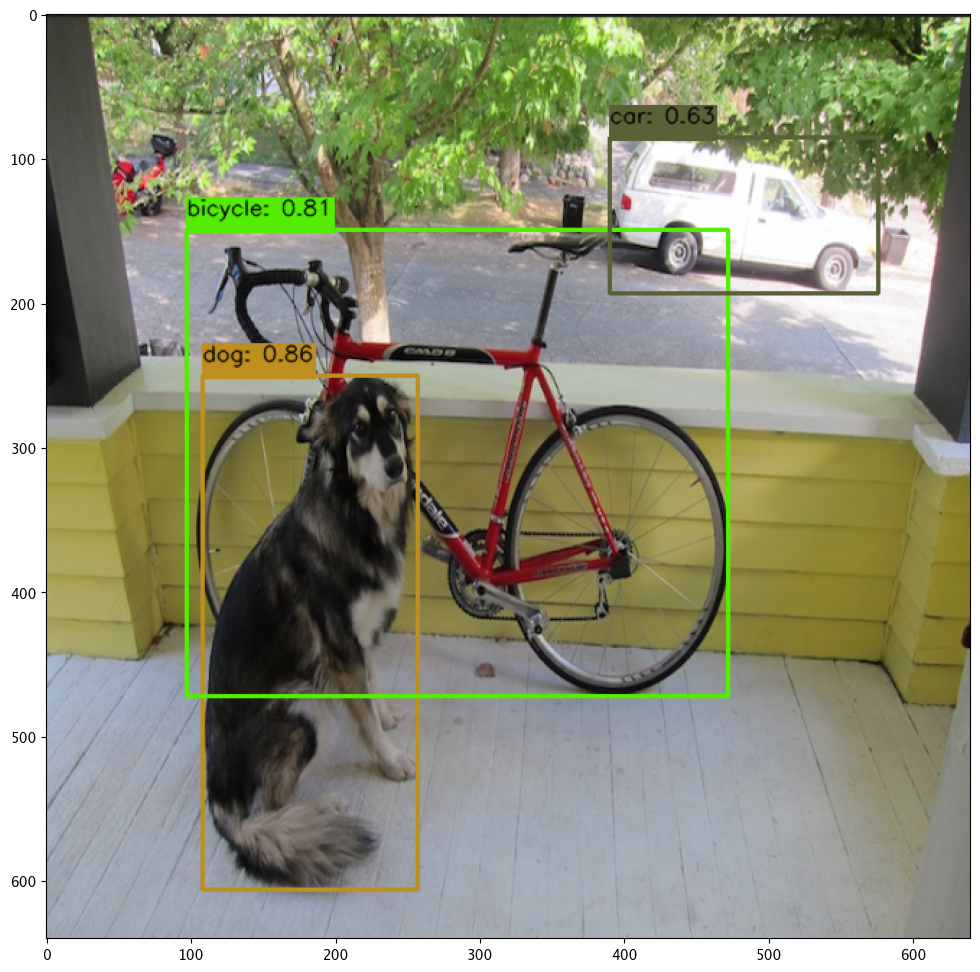

array([[[ 34,  34,  34],
        [ 35,  35,  35],
        [ 33,  33,  33],
        ...,
        [ 33,  33,  33],
        [ 33,  33,  33],
        [ 35,  35,  35]],

       [[ 33,  33,  33],
        [ 34,  34,  34],
        [ 34,  34,  34],
        ...,
        [ 34,  34,  34],
        [ 33,  33,  33],
        [ 34,  34,  34]],

       [[ 53,  54,  48],
        [ 54,  55,  49],
        [ 54,  55,  49],
        ...,
        [153, 178, 111],
        [151, 183, 108],
        [159, 176,  99]],

       ...,

       [[159, 167, 178],
        [159, 165, 177],
        [158, 163, 175],
        ...,
        [126, 127, 121],
        [127, 125, 120],
        [128, 120, 117]],

       [[160, 168, 179],
        [156, 162, 174],
        [152, 157, 169],
        ...,
        [126, 127, 121],
        [129, 127, 122],
        [127, 118, 116]],

       [[155, 163, 174],
        [155, 162, 174],
        [152, 158, 170],
        ...,
        [127, 127, 121],
        [130, 126, 122],
        [128, 119, 116]]

In [ ]:
## blank space to create test data and perform sample inferences and draw bounding boxes on the image

width, height = 640, 640
tensor1, resizedImage1 = cvDemo.loadImageAndResize('../data/dogbike.png', width, height)
tensor1.flatten()

# add the tensor to a DataFrame and save the DataFrame in pandas record format
df = util.convert_data(tensor1, 'images')


results = pipeline.infer(df)

# display the converted image and bounding boxes

confidence_thres = 0.50
iou_thres = 0.25

cvDemo.drawYolo8Boxes(results, resizedImage1, width, height, confidence_thres, iou_thres, draw=True)

## Undeploying Your Pipeline

You should always undeploy your pipelines when you are done with them, or don't need them for a while. This releases the resources that the pipeline is using for other processes to use. You can always redeploy the pipeline when you need it again. As a reminder, here are the commands to deploy and undeploy a pipeline:

```python

# "turn off" the pipeline and releaase its resources
my_pipeline.undeploy()
```

In [ ]:
## blank space to undeploy the pipeline
pipeline.undeploy()

name,yolov8n-tutorial
created,2024-11-04 16:29:35.658089+00:00
last_updated,2024-11-04 16:52:44.977005+00:00
deployed,False
workspace_id,12
workspace_name,workshop-workspace-cv-yolo-john
arch,x86
accel,none
tags,
versions,"0d136492-7fb6-411d-ae36-81099cf75f79, 9151d2ff-4cee-449a-ab01-eb35ae086a8a, 17064dc6-92e2-49c6-9bb5-19ad183b148d, 98851747-c689-4696-b3fc-040de773cc3a, 2e95dd38-566e-483e-8625-3fac1f69eef8, 1f2d7d9d-c627-4043-a462-fc0445e643a6, 685008b0-d557-4e6d-a17b-e1dd13767d40, ebeccd79-e6c3-4ccb-9d01-69b95c179e6d"
steps,yolov8n-tutorial


## Publish the Pipeline for Edge Deployment

It worked! For a demo, we'll take working once as "tested". So now that we've tested our pipeline, we are ready to publish it for edge deployment.

Publishing it means assembling all of the configuration files and model assets and pushing them to an Open Container Initiative (OCI) repository set in the Wallaroo instance as the Edge Registry service.  DevOps engineers then retrieve that image and deploy it through Docker, Kubernetes, or similar deployments.

See [Edge Deployment Registry Guide](https://staging.docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-edge-deployment/) for details on adding an OCI Registry Service to Wallaroo as the Edge Deployment Registry.

This is done through the SDK command `wallaroo.pipeline.publish(deployment_config)` which has the following parameters and returns.

#### Publish a Pipeline Parameters

The `publish` method takes the following parameters.  The containerized pipeline will be pushed to the Edge registry service with the model, pipeline configurations, and other artifacts needed to deploy the pipeline.

| Parameter | Type | Description |
|---|---|---|
| `deployment_config` | `wallaroo.deployment_config.DeploymentConfig` (*Optional*) | Sets the pipeline deployment configuration.  For example:    For more information on pipeline deployment configuration, see the [Wallaroo SDK Essentials Guide: Pipeline Deployment Configuration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-deployment-config/).

#### Publish a Pipeline Returns

| Field | Type | Description |
|---|---|---|
| id | integer | Numerical Wallaroo id of the published pipeline. |
| pipeline version id | integer | Numerical Wallaroo id of the pipeline version published. |
| status | string | The status of the pipeline publication.  Values include:  <ul><li>PendingPublish: The pipeline publication is about to be uploaded or is in the process of being uploaded.</li><li>Published:  The pipeline is published and ready for use.</li></ul> |
| Engine URL | string | The URL of the published pipeline engine in the edge registry. |
| Pipeline URL | string | The URL of the published pipeline in the edge registry. |
| Helm Chart URL | string | The URL of the helm chart for the published pipeline in the edge registry. |
| Helm Chart Reference | string | The help chart reference. |
| Helm Chart Version | string | The version of the Helm Chart of the published pipeline.  This is also used as the Docker tag. |
| Engine Config | `wallaroo.deployment_config.DeploymentConfig` | The pipeline configuration included with the published pipeline. |
| Created At | DateTime | When the published pipeline was created. |
| Updated At | DateTime | When the published pipeline was updated. |

### Publish the Pipeline for Edge Deployment Exercise

We will now publish the pipeline to our Edge Deployment Registry with the `pipeline.publish(deployment_config)` command.  `deployment_config` is an optional field that specifies the pipeline deployment.  This can be overridden by the DevOps engineer during deployment.

In this example, assuming that the pipeline was saved to the variable `my_pipeline`, we would publish it to the Edge Registry already stored in the Wallaroo instance and store the pipeline publish to the variable `my_pub` with the following command:

```python
my_pub=pipeline.publish(deploy_config)
# display the publish
my_pub
```


In [11]:
## blank space to publish the pipeline

my_pub=pipeline.publish(deploy_config)
# display the publish
my_pub


Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is publishing..... Published.


ID,8
Pipeline Name,yolov8n-tutorial
Pipeline Version,bf8021b0-08e8-4870-963b-704957c8a887
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/fitzroy-mini:v2024.2.0-5761
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/yolov8n-tutorial:bf8021b0-08e8-4870-963b-704957c8a887
Helm Chart URL,oci://ghcr.io/wallaroolabs/doc-samples/charts/yolov8n-tutorial
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:bd7210d1e8238285a9f1369987e9a6e47240df9b5d27e23ceb368f24abef0120
Helm Chart Version,0.0.1-bf8021b0-08e8-4870-963b-704957c8a887
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 1.0, 'memory': '512Mi'}, 'accel': 'none', 'arch': 'x86', 'gpu': False}}, 'engineAux': {'autoscale': {'type': 'none'}, 'images': {}}}"
User Images,[]


## List Published Pipelines

The method `wallaroo.client.list_pipelines()` shows a list of all pipelines in the Wallaroo instance, and includes the `published` field that indicates whether the pipeline was published to the registry (`True`), or has not yet been published (`False`).

### List Published Pipelines Exercise

List all pipelines and see which ones are published or not.  For example, if your client was saved to the variable `wl`, then the following will list the pipelines and display which ones are published.

```python
wl.list_pipelines()
```

In [ ]:
## blank space to list the pipelines and view which are published

wl.list_pipelines()

name,created,last_updated,deployed,workspace_id,workspace_name,arch,accel,tags,versions,steps,published
ccfraud-detector,2024-31-Oct 18:23:11,2024-31-Oct 18:37:35,False,10,workshop-finserv-john,x86,none,,"5c75bcaa-1d0d-437a-a425-533172a93112, 93a5709d-76f2-413d-b818-c6cd50767d71, 57659060-ca41-492c-811b-9ae2b368066a, cb236f0f-946a-4cc8-b52e-f1777af7b111, 72e0dbf8-d574-4888-8002-636079575534, ca121c30-8cfa-4420-8f71-bf47148d6ca3, a76ee1ea-bdee-4196-9c25-99af29abb597",classification-finserv-prime,True
imdb-reviewer,2024-29-Oct 17:06:42,2024-29-Oct 19:01:37,False,6,workshop-workspace-john-sentiment-analysis,x86,none,,"8b0682d5-5601-4bb5-b34f-2e8822e14e45, 78eed0bf-af64-430c-8183-069d66e91e54, 430b0a14-9b70-4c4f-964e-264d906149ee, ddfc04b1-a0a3-4524-a456-b71921de84ba, 31a95d69-2133-4c98-96bb-8069fd45abc8, 0e8ef023-1300-46b2-a341-5885ae131995, db04b467-d79d-4af5-aadd-2dae014aa7ca, 00e32b0f-bfce-4895-8a6c-9716c06245ed, 2542cba0-9ff5-46d8-9204-9e9b5327199e, 8cec1024-a9cf-4b19-b6b6-df506f92de23",embedder,True
imdb-reviewer,2024-01-Nov 17:41:20,2024-01-Nov 18:27:38,False,11,workshop-workspace-sentiment-analysis,x86,none,,"58f9cd8e-81d8-4fa9-8910-1124acbd626d, a84f07f6-2ad4-43c4-9ec5-c6318ea6550a, ea045efc-1cfb-4296-bece-f620cf479ed8, dc0fd017-f43f-4f00-821d-6e1a11ee88e2, a0d82d3f-14a3-4897-90b1-e4ca3e56d23c, 4024dae6-8e62-4720-8feb-c35c7224e1a7, f6287d00-b934-4ad8-9e92-cd20d544e6a5, d8d77a9d-5baa-4979-9e59-d746ce94dde2, 6a333530-d25a-4f42-9c74-97b5a96a150a",embedder,True
hf-summarizer,2024-29-Oct 19:53:41,2024-29-Oct 20:37:39,False,7,workshop-workspace-summarization,x86,none,,"bc152b34-793b-4e7e-8a81-8e4345a62bdc, e7d816a1-b458-4f91-b845-4e3b53418154, e57078b2-0190-4f55-8a6c-4cfdba2c63a6, 74db0fd3-f1b6-429c-a082-04e2aedcc4e6, e216b612-9b34-44c7-9a02-6812b2b8838d",hf-summarizer,True
yolov8n-tutorial,2024-04-Nov 16:29:35,2024-04-Nov 16:53:39,False,12,workshop-workspace-cv-yolo-john,x86,none,,"bf8021b0-08e8-4870-963b-704957c8a887, 0d136492-7fb6-411d-ae36-81099cf75f79, 9151d2ff-4cee-449a-ab01-eb35ae086a8a, 17064dc6-92e2-49c6-9bb5-19ad183b148d, 98851747-c689-4696-b3fc-040de773cc3a, 2e95dd38-566e-483e-8625-3fac1f69eef8, 1f2d7d9d-c627-4043-a462-fc0445e643a6, 685008b0-d557-4e6d-a17b-e1dd13767d40, ebeccd79-e6c3-4ccb-9d01-69b95c179e6d",yolov8n-tutorial,True
rental-forecast,2024-29-Oct 21:00:36,2024-30-Oct 21:07:35,False,8,workshop-workspace-forecast,x86,none,,"027b3811-c07e-4807-a201-caa0b22e9fb7, 7936ad28-8cc4-44e9-8002-119a773ef9c6, beca3565-bb16-41ca-83d6-cb6d9ba3514e, 585ee8cd-2f5e-4a1e-bb0d-6c88e6d94d3e, ceff9712-715b-41e6-a124-b174b62a9654, 0250f403-07c6-4b01-83bc-eebdc09bca22, 31b515bb-807f-4d64-b105-fc0ae6a582f2, 614a34e0-6024-4245-9919-1a85b7a1e5d2, 6a593faf-bea3-4f57-b9ec-5c1afe7f93a7, 4dce5be3-926c-419f-9868-3dbea7baf3c1, a601ce07-937c-436a-9735-0ac842173dfb, c0d16da5-5db7-4af1-95e4-cb0c316a4ef3, bd5eb43f-5a2b-493c-a04b-863dccccb55f, 89729096-6581-42b8-9b06-10d580d31e11, b98b86fb-5941-45b6-af5d-c33f80ba7986, aead5518-ffb2-4d18-8898-89575ba90a9f, a2a887c0-a91b-4af7-b579-506c79631fa4, b8ac836a-903b-4327-a4c9-5cc7fb382aa7, 3e18cd2d-c006-497b-a756-5ecc95aa8439, bd3f7d6a-e246-4456-98b9-35b90990b86d",forecast-control-model,True
ccfraud-detector,2024-30-Oct 21:03:49,2024-30-Oct 21:11:18,False,9,workshop-finserv-jch,x86,none,,"f0d85564-7370-4e23-9a7a-d71b7c76bd71, fce1feba-954d-4118-8e48-bdabf404502b, 53b85633-3718-40f3-bb4f-833f298ce479, 7e2ceb8b-8bfb-4484-9ceb-be373ddad059, 556952a1-771a-47fa-997e-c0852d830bac, 5d1a453b-38d2-4619-a2b0-4adfec824345, ba96ee7a-e26d-4ce6-8b00-b1bee131592c",classification-finserv-prime,False


## List Publishes from a Pipeline

All publishes created from a pipeline are displayed with the `wallaroo.pipeline.publishes` method.  The `pipeline_version_id` is used to know what version of the pipeline was used in that specific publish.  This allows for pipelines to be updated over time, and newer versions to be sent and tracked to the Edge Deployment Registry service.

### List Publishes Parameters

N/A

### List Publishes Returns

A List of the following fields:

| Field | Type | Description |
|---|---|---|
| id | integer | Numerical Wallaroo id of the published pipeline. |
| pipeline_version_id | integer | Numerical Wallaroo id of the pipeline version published. |
| engine_url | string | The URL of the published pipeline engine in the edge registry. |
| pipeline_url | string | The URL of the published pipeline in the edge registry. |
| created_by | string | The email address of the user that published the pipeline.
| Created At | DateTime | When the published pipeline was created. |
| Updated At | DateTime | When the published pipeline was updated. |

### List Publishes from a Pipeline Exercise

List all of the publishes from our pipeline.  For example, if our pipeline is `my_pipeline`, then we would list all publishes from the pipeline with the following:

```python
my_pipeline.publishes()
```

In [ ]:
## blank space to list pipeline publishes

pipeline.publishes()

id,pipeline_version_name,engine_url,pipeline_url,created_by,created_at,updated_at
8,bf8021b0-08e8-4870-963b-704957c8a887,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/fitzroy-mini:v2024.2.0-5761,ghcr.io/wallaroolabs/doc-samples/pipelines/yolov8n-tutorial:bf8021b0-08e8-4870-963b-704957c8a887,john.hansarick@wallaroo.ai,2024-04-Nov 16:53:40,2024-04-Nov 16:53:40


## Congratulations!

You have now 

* Created a workspace and set it as the current workspace.
* Uploaded an ONNX model.
* Created a Wallaroo pipeline, and set the most recent version of the uploaded model as a pipeline step.
* Successfully send data to your pipeline for inference through the SDK and through an API call.


## DevOps - Pipeline Edge Deployment

Once a pipeline is deployed to the Edge Registry service, it can be deployed in environments such as Docker, Kubernetes, or similar container running services by a DevOps engineer.  Docker Run and Helm Install templates are provided as part of the pipeline publish display from the Wallaroo SDK.

## Edge Deployed Pipeline API Endpoints

Once deployed, we can check the pipelines and models available.  We'll use a `curl` command, but any HTTP based request will work the same way.

### Pipelines Endpoints

The endpoint `/pipelines` returns:

* **id** (*String*):  The name of the pipeline.
* **status** (*String*):  The status as either `Running`, or `Error` if there are any issues.

For this example, the deployment is made on a machine called `testboy.local`.  Replace this URL with the URL of you edge deployment.

#### Pipelines Endpoints Exercise

Use the following `curl` command to view the pipeline data.  For example, if the pipeline was deployed on `localhost`, then the command would be:

```bash
!curl locahost:8080/pipelines
```

In [ ]:
## blank space to display deployed pipelines on the edge device

!curl localhost:8080/pipelines

### Models Endpoints

The endpoint `/models` returns a List of models with the following fields:

* **name** (*String*): The model name.
* **sha** (*String*): The sha hash value of the ML model.
* **status** (*String*):  The status of either Running or Error if there are any issues.
* **version** (*String*):  The model version.  This matches the version designation used by Wallaroo to track model versions in UUID format.

#### Models Endpoints Exercise

Use the following `curl` command to view the models data.  For example, if the pipeline was deployed on `localhost`, then the command would be:

```bash
!curl locahost:8080/models
```

In [ ]:
## blank space show models deployed on the edge device

!curl localhost:8080/models

### Edge Deployed Inference

The inference endpoint takes the following pattern:

* `/pipelines/{pipeline-name}`:  The `pipeline-name` is the same as returned from the [`/pipelines`](#list-pipelines) endpoint as `id`.

Wallaroo inference endpoint URLs accept the following data inputs through the `Content-Type` header:

* `Content-Type: application/vnd.apache.arrow.file`: For Apache Arrow tables.
* `Content-Type: application/json; format=pandas-records`: For pandas DataFrame in record format.

It returns a `application/json; format=pandas-records` - the same pandas record we've been working with.

### Edge Deployed Inference Exercise

Perform an inference on the deployed pipeline using `curl`.  This command will look like this:

```bash
!curl -X POST localhost:8080/infer -H "Content-Type: application/json; format=pandas-records" --data @../data/singleton.df.json
```

In [ ]:
## blank space to perform inference on edge deployment

!curl -X POST localhost:8080/infer \
    -H "Content-Type:application/json; format=pandas-records" \
    --data-binary @../data/dogbike.df.json > edge.df.json